# Extract Image from Raw Files

This notebook tests code that extract .tif images from .raw (binary) files. I aim to create a "to_tif.py" equivalence for .raw files. 

## The structure of .raw file 

.raw file is a binary file containing all the images and their corresponding image numbers. Such structure can be illustrated as the following sketch
<img src='doc-images/raw-structure.png'>

<font color='red'> It's kind of weird that the frame number is in different data type from that of pixel values. Probably this is to distinguish frame # from pixels. </font>

## How I seperate the images

Compared to using a for loop to iterate over all the images one-by-one, reading the whole stack is apparently more efficient. I will read the whole stack, and then rearrange the array as the following sketch, so that I can seperate the images. 
<img src='doc-images/seperate.png'>

Then, the sequential "pixel info" is reshaped into the actual dimensions of images (with height and width), as shown below:


<img src="doc-images/reshape.png">

Finally, we can save the images as a sequence of .tif files, which are easier to play with. 

## Code part

In [15]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import io

In [4]:
folder = '/home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files'
image = 'RawImage.raw'
filename = os.path.join(folder, image)
h, w = 1024, 1024

In [50]:
# read the whole binary file
a = np.fromfile(filename, dtype='uint16')

In [8]:
# rearrange so that there is one image per row
b = a.reshape(29, h*w+2)

In [20]:
# seperate frame numbers from images
labels = b[:, :1]
images = b[:, 2:]

In [11]:
# reshape the one-dimensional images into their actual dimensions
images_reshape = images.reshape(29, h, w)

(-0.5, 1023.5, 1023.5, -0.5)

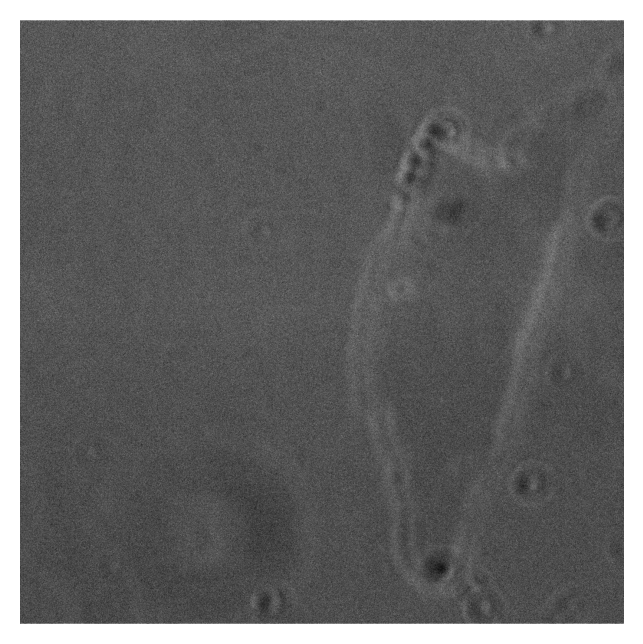

In [14]:
# now, all images can be accessed by images_reshape[n]
# where n is 0, 1, ...
# for example, I show the first frame below
plt.figure(dpi=200)
plt.imshow(images_reshape[0], cmap='gray')
plt.axis('off')

In [17]:
io.imsave('doc-images/py-4.tif', images_reshape[4])

<ipython-input-17-64d6e434cbf4>:1: UserWarning: doc-images/py-4.tif is a low contrast image
  io.imsave('doc-images/py-4.tif', images_reshape[4])


It's worth comparing the outcome with the MATLAB code.

First image 
<img src='doc-images/compare-1.png'>

5th image
<img src='doc-images/compare-5.png'>

## Save .tif files

We save .tif images in folder "images" which is in the same directory as the .raw file. 

In [23]:
save_folder = os.path.join(folder, 'images')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
for num, img in enumerate(images_reshape):
    io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)

<ipython-input-23-aef7682a95e2>:5: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0000.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-23-aef7682a95e2>:5: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0001.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-23-aef7682a95e2>:5: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0002.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-23-aef7682a95e2>:5: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0003.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-23-aef7682a95e2>:5: UserWarning: /home/zhengyang/Document

## Wrap in a function

1. Check for necessary files: RawImage.raw, RawImageInfo.txt, ...
2. Read image info from RawImageInfo.txt
3. Read RawImage.raw and save .tif images

In [27]:
def check_necessary_files(folder):
    """
    Check for necessary files: RawImage.raw, RawImageInfo.txt, ...
    """
    return os.path.exists(os.path.join(folder, 'RawImage.raw')) and \
            os.path.exists(os.path.join(folder, 'RawImageInfo.txt'))

In [29]:
# test check_necessary_files(folder)
folder = '/home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files'
check_necessary_files(folder)

True

In [46]:
def read_raw_image_info(info_file):
    """
    Read image info, such as fps and image dimensions,
    from RawImageInfo.txt
    """
    with open(info_file, 'r') as f:
        a = f.read()
    fps, h, w = a.split('\n')[0:3]
    return int(fps), int(h), int(w)

In [47]:
# test read_raw_image_info(info_file)
info_file = os.path.join(folder, 'RawImageInfo.txt')
read_raw_image_info(info_file)

(80, 1024, 1024)

In [56]:
def raw_to_tif(raw_file, img_dim, save_folder):
    """
    Read RawImage.raw and save .tif images
    
    Args:
    raw_file -- the directory of .raw file
    img_dim -- the (h, w) tuple of each frame
    """
    
    a = np.fromfile(raw_file, dtype='uint16')
    # to make sure the raw_file contains correct information,
    # we check if the number of numbers in array a can be
    # divided exactly by h*w+2
    h, w = img_dim
    assert(a.shape[0] % (h*w+2) == 0)
    num_images = a.shape[0] // (h*w+2)
    img_in_row = a.reshape(num_images, h*w+2)
    labels = img_in_row[:, :1] # not in use currently
    images = img_in_row[:, 2:]
    images_reshape = images.reshape(num_images, h, w)
    
    # save the images as .tif sequence
    if os.path.exists(save_folder) == False:
        os.makedirs(save_folder)
    for num, img in enumerate(images_reshape):
        io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)

In [57]:
# test raw_to_tif(raw_file, img_dim, save_folder)
raw_file = os.path.join(folder, 'RawImage.raw')
img_dim = (1024, 1024)
save_folder = os.path.join(folder, 'images')
raw_to_tif(raw_file, img_dim, save_folder)

<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0000.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0001.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0002.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0003.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Doc

In [58]:
# combine the functions
def extract_images(folder):
    if check_necessary_files(folder):
        info_file = os.path.join(folder, 'RawImageInfo.txt')
        raw_file = os.path.join(folder, 'RawImage.raw')
        save_folder = os.path.join(folder, 'images')
        fps, h, w = read_raw_image_info(info_file)
        raw_to_tif(raw_file, (h, w), save_folder)
    else:
        print('Imcomplete files')

In [59]:
# test extract_images(folder)
folder = '/home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files'
extract_images(folder)

<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0000.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0001.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0002.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Documents/MATLAB/image-processing/ExtractImage/test-files/images/0003.tif is a low contrast image
  io.imsave(os.path.join(save_folder, '{:04d}.tif'.format(num)), img)
<ipython-input-56-054b90740389>:26: UserWarning: /home/zhengyang/Doc